In [1]:
import numpy as np

from TraceSimulator import TraceSimulator
from trace_IO import *
from OptimumFilter import *
from OF import *
import matplotlib.pyplot as plt


In [2]:
sampling_frequency = 3906250
template_1 = np.load("./sub_ch_template.npy")
template_2 = np.load("./vac_ch45_low_eng.npy")
template_3 = np.load("./vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger_1 = OFtrigger(template_1, noise_psd, sampling_frequency)
trigger_2 = OFtrigger(template_2, noise_psd, sampling_frequency)
trigger_3 = OFtrigger(template_3, noise_psd, sampling_frequency)


In [3]:
loaded_traces = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces.shape

(1000, 54, 32768)

In [7]:
# loaded_traces should be shape (1000, 54, trace_length)
n_events = len(loaded_traces)
amps_all = np.zeros((n_events, 54))
chisqs_all = np.zeros((n_events, 54))

for i in range(n_events):
    traces = loaded_traces[i]
    for ch in range(54):
        if ch <= 44:
            amp, chisq = trigger_1.fit(traces[ch])
        elif ch == 45:
            amp, chisq = trigger_2.fit(traces[ch])
        else:
            amp, chisq = trigger_3.fit(traces[ch])

        amps_all[i, ch] = amp
        chisqs_all[i, ch] = chisq

# Group amplitude data by channel ranges
amps_sub = amps_all[:, :45].flatten()     # Channels 0–44
amps_45 = amps_all[:, 45]
amps_46plus = amps_all[:, 46:].flatten()  # Channels 46–53



In [8]:
amps_all.shape

(1000, 54)

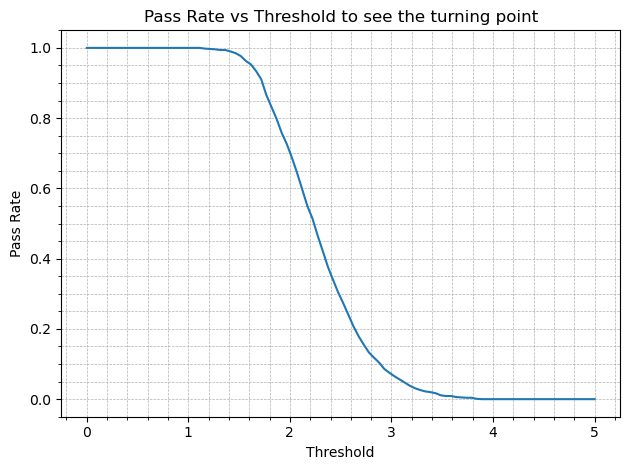

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate amps_all for demonstration (1000 events, 54 channels)
np.random.seed(0)
amps_all = np.random.normal(loc=0, scale=1, size=(1000, 54))

# Define a range of thresholds
thresholds = np.linspace(0, 5, 100)
pass_rates = []

# Compute pass rate for each threshold
for thresh in thresholds:
    passed = np.any(amps_all > thresh, axis=1)  # Event passes if any channel exceeds threshold
    pass_rate = np.sum(passed) / amps_all.shape[0]
    pass_rates.append(pass_rate)

# Plot pass rate vs threshold
plt.figure()
plt.plot(thresholds, pass_rates)
plt.xlabel('Threshold')
plt.ylabel('Pass Rate')
plt.title('Pass Rate vs Threshold to see the turning point')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()


Processing ER+NR energy = 5 eV
Processing ER+NR energy = 10 eV
Processing ER+NR energy = 15 eV
Processing ER+NR energy = 20 eV
Processing ER+NR energy = 25 eV
Processing ER+NR energy = 30 eV
Processing ER+NR energy = 35 eV
Processing ER+NR energy = 40 eV
Processing ER+NR energy = 45 eV
Processing ER+NR energy = 50 eV


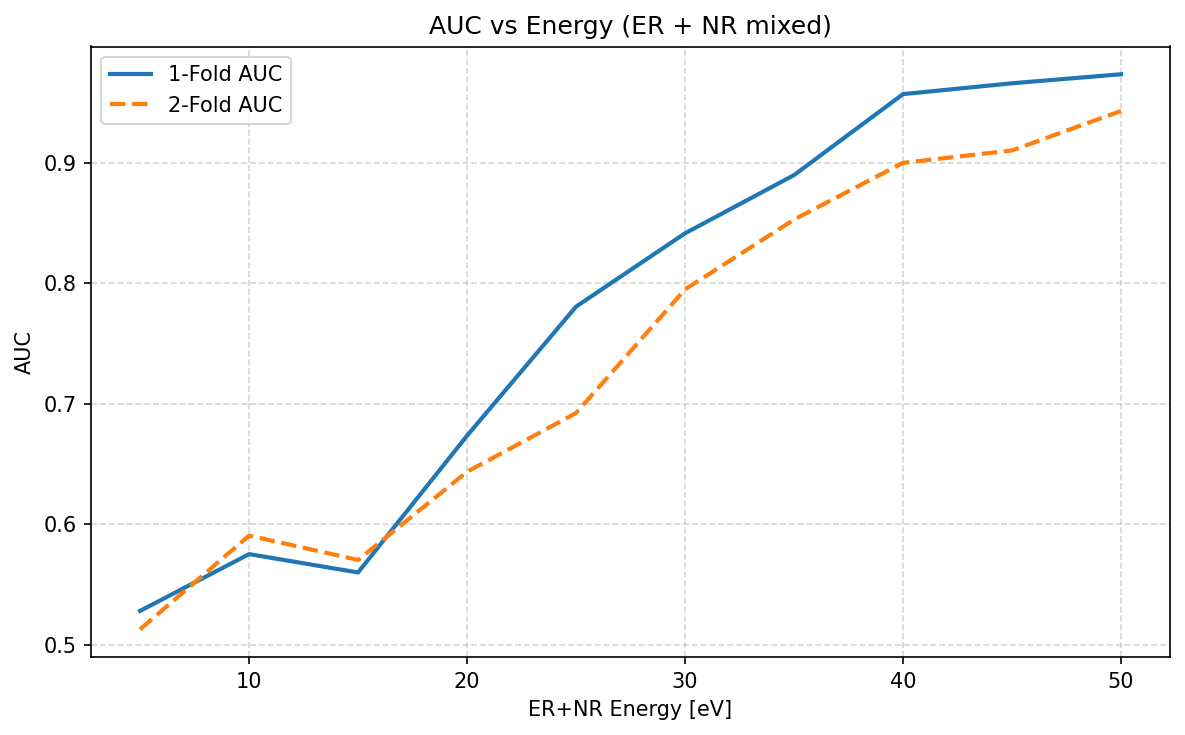

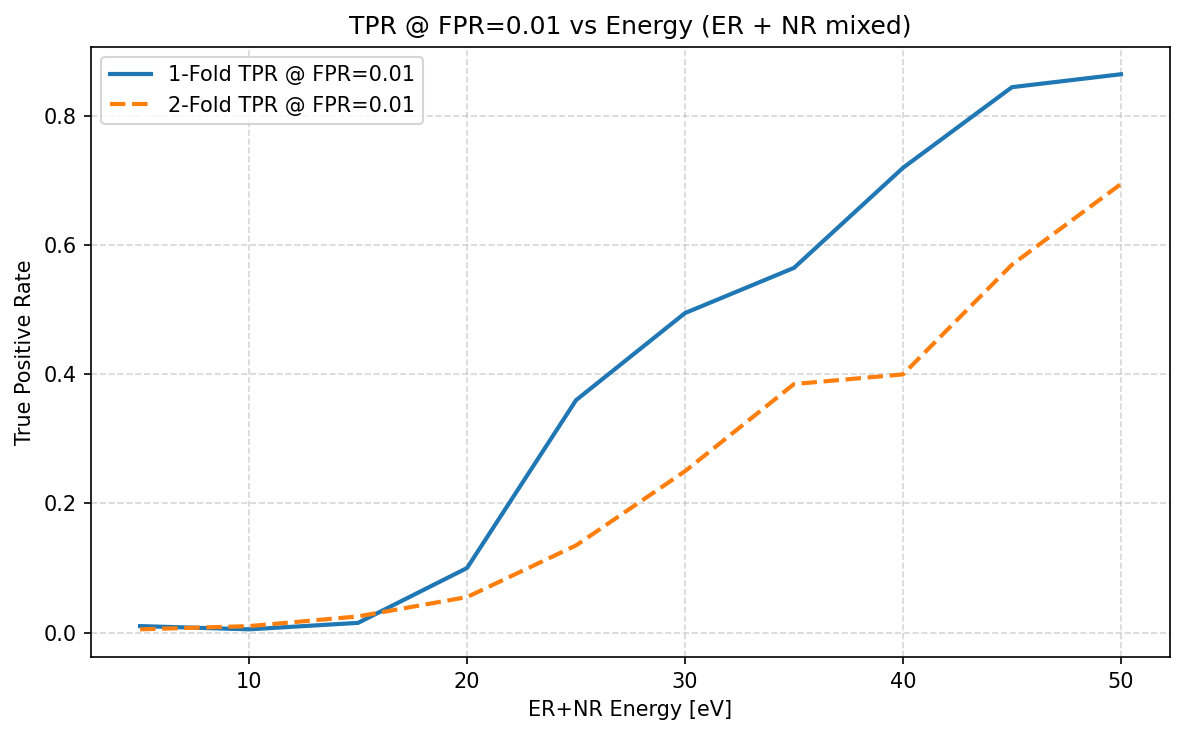

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def compute_amplitudes(traces):
    n_events = traces.shape[0]
    n_channels = traces.shape[1]
    all_amps = np.zeros((n_events, n_channels))

    for i in range(n_events):
        event = traces[i]
        for ch in range(n_channels):
            if ch <= 44:
                amp, _ = trigger_1.fit(event[ch])
            elif ch == 45:
                amp, _ = trigger_2.fit(event[ch])
            else:
                amp, _ = trigger_3.fit(event[ch])
            all_amps[i, ch] = amp

    return all_amps

# === Load background (noise)
loaded_traces_neg = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
amps_neg = compute_amplitudes(loaded_traces_neg)

# === Energy scan
energies = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Add more if you have
fpr_target = 0.01

tpr_1_list = []
tpr_2_list = []
auc_1_list = []
auc_2_list = []

for energy in energies:
    print(f"Processing ER+NR energy = {energy} eV")

    path_er = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    path_nr = f"/ceph/dwong/trigger_samples/NR/traces_energy_{energy}.zst"

    loaded_traces_er = load_traces_from_zstd(path_er, n_traces=100)
    loaded_traces_nr = load_traces_from_zstd(path_nr, n_traces=100)

    loaded_traces_pos = np.concatenate([loaded_traces_er, loaded_traces_nr], axis=0)
    amps_pos = compute_amplitudes(loaded_traces_pos)

    # Scores
    score_1fold_pos = amps_pos.max(axis=1)
    score_1fold_neg = amps_neg.max(axis=1)

    # 2-fold logic: second largest amplitude per event
    score_2fold_pos = np.partition(amps_pos, -2, axis=1)[:, -2]
    score_2fold_neg = np.partition(amps_neg, -2, axis=1)[:, -2]

    # Labels
    y_true = np.concatenate([
        np.ones(len(score_1fold_pos)),
        np.zeros(len(score_1fold_neg))
    ])

    # 1-fold
    scores_1 = np.concatenate([score_1fold_pos, score_1fold_neg])
    fpr_1, tpr_1, _ = roc_curve(y_true, scores_1)
    auc_1 = auc(fpr_1, tpr_1)
    auc_1_list.append(auc_1)

    idx = np.searchsorted(fpr_1, fpr_target, side="right") - 1
    tpr_1_list.append(tpr_1[idx] if idx >= 0 else 0)

    # 2-fold
    scores_2 = np.concatenate([score_2fold_pos, score_2fold_neg])
    fpr_2, tpr_2, _ = roc_curve(y_true, scores_2)
    auc_2 = auc(fpr_2, tpr_2)
    auc_2_list.append(auc_2)

    idx = np.searchsorted(fpr_2, fpr_target, side="right") - 1
    tpr_2_list.append(tpr_2[idx] if idx >= 0 else 0)

# === Plot AUC vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, auc_1_list, label="1-Fold AUC", linewidth=2)
plt.plot(energies, auc_2_list, '--', label="2-Fold AUC", linewidth=2)
plt.xlabel("ER+NR Energy [eV]")
plt.ylabel("AUC")
plt.title("AUC vs Energy (ER + NR mixed)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot TPR@FPR=0.01 vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, tpr_1_list, label="1-Fold TPR @ FPR=0.01", linewidth=2)
plt.plot(energies, tpr_2_list, '--', label="2-Fold TPR @ FPR=0.01", linewidth=2)
plt.xlabel("ER+NR Energy [eV]")
plt.ylabel("True Positive Rate")
plt.title("TPR @ FPR=0.01 vs Energy (ER + NR mixed)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


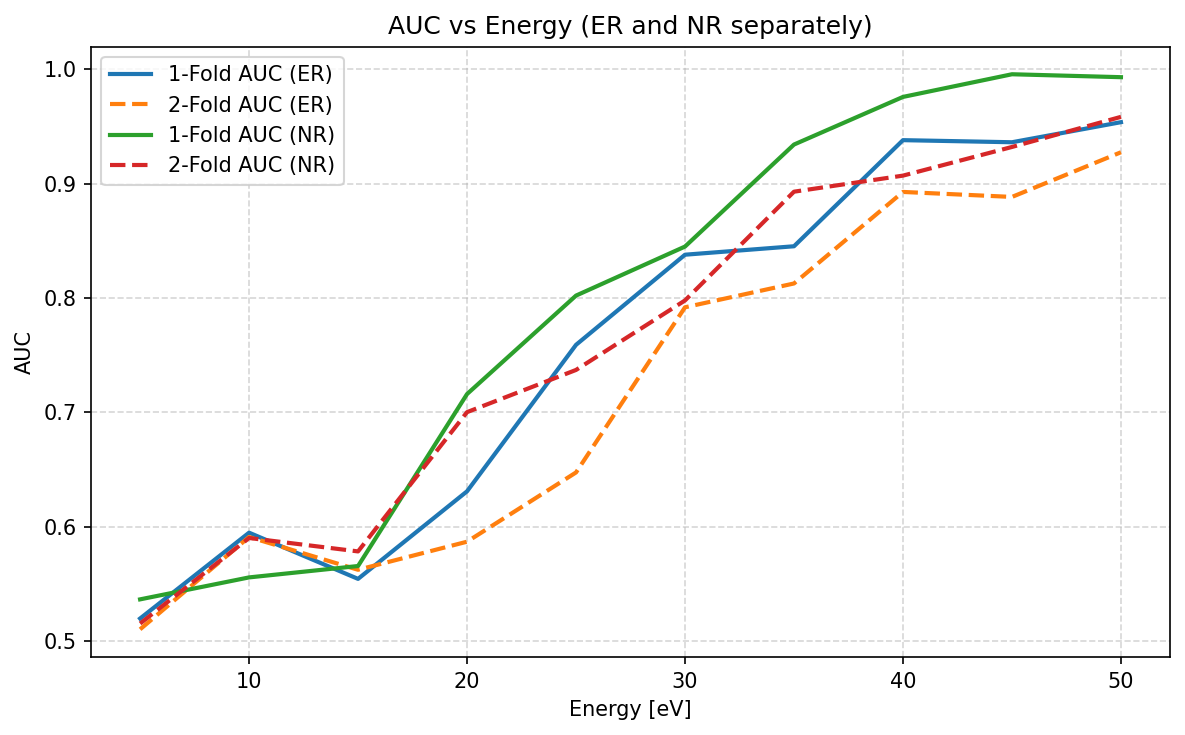

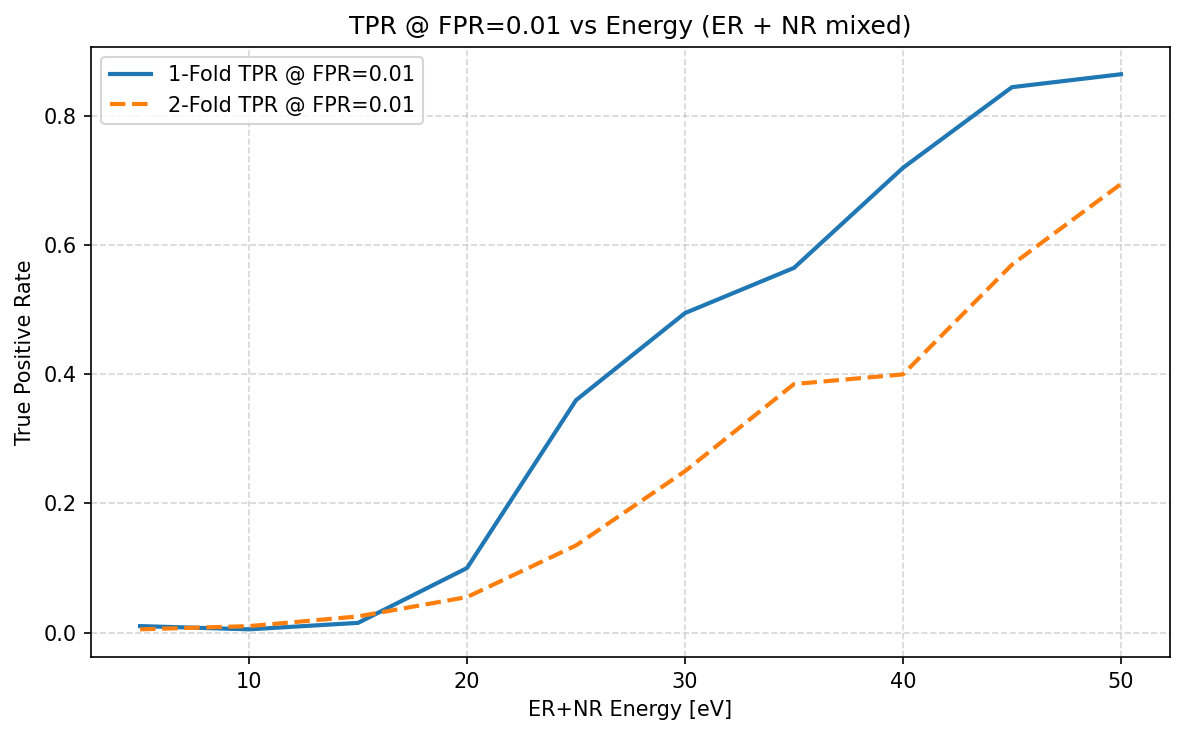

In [17]:
# === Plot AUC vs Energy for ER and NR separately
auc_1_er, auc_2_er = [], []
auc_1_nr, auc_2_nr = [], []

for energy in energies:
    path_er = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    path_nr = f"/ceph/dwong/trigger_samples/NR/traces_energy_{energy}.zst"

    traces_er = load_traces_from_zstd(path_er, n_traces=100)
    traces_nr = load_traces_from_zstd(path_nr, n_traces=100)

    amps_er = compute_amplitudes(traces_er)
    amps_nr = compute_amplitudes(traces_nr)

    s1_er = amps_er.max(axis=1)
    s1_nr = amps_nr.max(axis=1)
    s2_er = np.partition(amps_er, -2, axis=1)[:, -2]
    s2_nr = np.partition(amps_nr, -2, axis=1)[:, -2]

    y_er = np.concatenate([np.ones(len(s1_er)), np.zeros(len(score_1fold_neg))])
    y_nr = np.concatenate([np.ones(len(s1_nr)), np.zeros(len(score_1fold_neg))])

    s1_all_er = np.concatenate([s1_er, score_1fold_neg])
    s2_all_er = np.concatenate([s2_er, score_2fold_neg])
    s1_all_nr = np.concatenate([s1_nr, score_1fold_neg])
    s2_all_nr = np.concatenate([s2_nr, score_2fold_neg])

    fpr, tpr, _ = roc_curve(y_er, s1_all_er)
    auc_1_er.append(auc(fpr, tpr))
    fpr, tpr, _ = roc_curve(y_er, s2_all_er)
    auc_2_er.append(auc(fpr, tpr))

    fpr, tpr, _ = roc_curve(y_nr, s1_all_nr)
    auc_1_nr.append(auc(fpr, tpr))
    fpr, tpr, _ = roc_curve(y_nr, s2_all_nr)
    auc_2_nr.append(auc(fpr, tpr))

# Plot
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, auc_1_er, label="1-Fold AUC (ER)", linewidth=2)
plt.plot(energies, auc_2_er, '--', label="2-Fold AUC (ER)", linewidth=2)
plt.plot(energies, auc_1_nr, label="1-Fold AUC (NR)", linewidth=2)
plt.plot(energies, auc_2_nr, '--', label="2-Fold AUC (NR)", linewidth=2)
plt.xlabel("Energy [eV]")
plt.ylabel("AUC")
plt.title("AUC vs Energy (ER and NR separately)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot TPR@FPR=0.01 vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, tpr_1_list, label="1-Fold TPR @ FPR=0.01", linewidth=2)
plt.plot(energies, tpr_2_list, '--', label="2-Fold TPR @ FPR=0.01", linewidth=2)
plt.xlabel("ER+NR Energy [eV]")
plt.ylabel("True Positive Rate")
plt.title("TPR @ FPR=0.01 vs Energy (ER + NR mixed)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
